In [1]:
import anndata
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scanpy as sc
import gseapy as gp

from src.plotter import savefig

In [2]:
senset = np.array(open("resources/SenSet.txt").read().splitlines())

In [3]:
raw = pd.read_excel("resources/Figure4-source-data.xlsx", skiprows=21, nrows=12, index_col=0).reset_index(drop=True)
raw.rename(columns={'Unnamed: 1': 'Subject'}, inplace=True)

In [4]:
raw

,Subject,Age,Bleo Control,Bleomycin,Doxo Control,Doxo
0,LTC 113,56.0,1.345755,4.179196,1.649503,3.278194
1,LTC 117,73.0,1.360171,2.585023,0.547613,1.540433
2,LTC 119,38.0,NaN,NaN,0.387924,0.826125
3,LTC 120,21.0,0.355945,2.230044,NaN,NaN
4,LTC 121,62.0,1.178557,3.072720,NaN,NaN
5,LTC 124,36.0,1.760405,2.053929,0.988968,2.563190
6,LTC 127,41.0,0.079512,3.969642,1.600759,1.825554
7,LTC 137,78.0,0.919656,2.600700,0.825232,1.994843
8,AVERAGE,NaN,1.000000,2.955894,1.000000,2.004723
9,Standard deviation,NaN,NaN,0.830854,NaN,0.845041


In [5]:
subj_to_ratio = []
for i, row in raw.iterrows():
    if not row['Subject'].startswith('LTC'):
        continue
    if not pd.isna(row['Bleo Control']):
        subj_to_ratio.append({
            "Subject": row['Subject'],
            "Condition": 'Bleo',
            "Fold Change": row['Bleomycin'] / row['Bleo Control'],
        })
    if not pd.isna(row['Doxo Control']):
        subj_to_ratio.append({
            "Subject": row['Subject'],
            "Condition": 'Doxo',
            "Fold Change": row['Doxo'] / row['Doxo Control'],
        })
subj_to_ratio = pd.DataFrame(subj_to_ratio)

In [6]:
subj_to_ratio['Subject'].unique()

array(['LTC 113', 'LTC 117', 'LTC 119', 'LTC 120', 'LTC 121', 'LTC 124',
       'LTC 127', 'LTC 137'], dtype=object)

In [7]:
def split_and_map(v):
    cond, subject = v.split('_')
    if cond == 'control' and subject[0] == 'E':
        return f"{subject} (Rad control)"
    if cond == 'control':
        return f"{subject} (Bleo control)"
    if cond == 'dmso':
        return f"{subject} (Doxo control)"
    if cond == 'doxo':
        return f"{subject} (Doxo)"
    if cond == 'bleo':
        return f"{subject} (Bleo)"
    assert cond == 'rad', cond
    return f"{subject} (Rad)"

In [8]:
adata = anndata.read_h5ad('data/Integrated-annotated.h5ad')

In [9]:
obs = adata.obs.copy()
obs['sample'] = pd.Categorical(
    obs['batch_ID'].map(split_and_map),
    categories=[
        "LTC120 (Bleo control)",
        "LTC124 (Bleo control)",
        "LTC113 (Bleo control)",
        "LTC117 (Bleo control)",
        "LTC120 (Bleo)",
        "LTC124 (Bleo)",
        "LTC113 (Bleo)",
        "LTC117 (Bleo)",
        "LTC124 (Doxo control)",
        "LTC113 (Doxo control)",
        "LTC117 (Doxo control)",
        "LTC124 (Doxo)",
        "LTC113 (Doxo)",
        "LTC117 (Doxo)",
        "E170 (Rad control)",
        "E185 (Rad control)",
        "E187 (Rad control)",
        "E196 (Rad control)",
        "E170 (Rad)",
        "E185 (Rad)",
        "E187 (Rad)",
        "E196 (Rad)",
    ]
)
adata.obs['sample'] = obs['sample']

In [10]:
sc.pp.log1p(adata)

In [11]:
def plot_subject(subj, cond, gene):
    ctrl_adata = adata[adata.obs['sample'] == f"{subj} ({cond} control)", gene].copy()
    cond_adata = adata[adata.obs['sample'] == f"{subj} ({cond})", gene].copy()
    x_ctrl = ctrl_adata.X.toarray().ravel()
    x_cond = cond_adata.X.toarray().ravel()
    cond_name = [f"{cond} control"] * len(x_ctrl) + [cond] * len(x_cond)

    positive_cells_ctrl = (x_ctrl > 0).mean()
    positive_cells_cond = (x_cond > 0).mean()
    return positive_cells_cond / positive_cells_ctrl

In [12]:
subj_to_ratio["Level"] = "IHF"
patients = ["LTC 113", "LTC 117", "LTC 120", "LTC 124", "LTC 113", "LTC 117", "LTC 124"]
subj_to_ratio = subj_to_ratio[subj_to_ratio['Subject'].isin(patients)]

In [13]:
subj_to_ratio

,Subject,Condition,Fold Change,Level
0,LTC 113,Bleo,3.105467,IHF
1,LTC 113,Doxo,1.987383,IHF
2,LTC 117,Bleo,1.900514,IHF
3,LTC 117,Doxo,2.812994,IHF
5,LTC 120,Bleo,6.265136,IHF
7,LTC 124,Bleo,1.166737,IHF
8,LTC 124,Doxo,2.591782,IHF


In [14]:
fc = []
for patient, cond in zip(patients, ["Bleo"] * 4 + ["Doxo"] * 3):
    rat = plot_subject(patient.replace(" ", ""), cond, "CDKN1A")
    fc.append({
        "Subject": patient,
        "Condition": cond,
        "Fold Change": rat,
        "Level": "single-nuc",
    })
fc = pd.DataFrame(fc)

In [15]:
results = pd.concat([subj_to_ratio, fc])

In [16]:
subj_to_ratio.sort_values(["Subject", "Condition"], inplace=True, ignore_index=True)
fc.sort_values(["Subject", "Condition"], inplace=True, ignore_index=True)

assert subj_to_ratio["Subject"].equals(fc["Subject"])
assert subj_to_ratio["Condition"].equals(fc["Condition"])

In [17]:
data = pd.concat([subj_to_ratio.add_prefix("IHF-"), fc.add_prefix("sn-")], axis=1)

In [112]:
data.to_csv("resources/IHF-Single-Nuc-Correlation.csv")

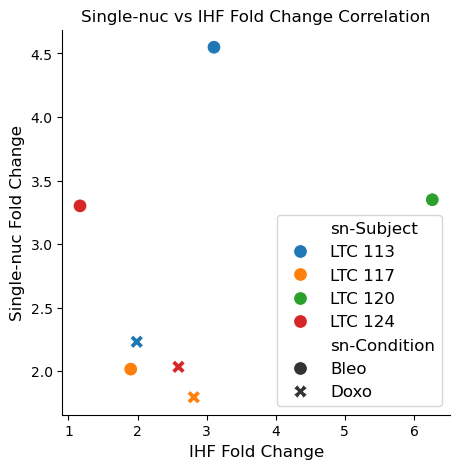

In [18]:
fig, ax = plt.subplots(figsize=(5, 5))

sns.scatterplot(
    data,
    x="IHF-Fold Change",
    y="sn-Fold Change",
    style="sn-Condition",
    hue="sn-Subject",
    s=100,
)

ax.set_xlabel("IHF Fold Change", fontsize=12)
ax.set_ylabel("Single-nuc Fold Change", fontsize=12)
ax.legend(fontsize=12)

ax.set_title("Single-nuc vs IHF Fold Change Correlation", fontsize=12)

sns.despine()
# savefig("figures/Supplement/chunks/sn-IHF-correlation.pdf")
plt.show()

## ssGSEA

In [19]:
sc.pp.filter_genes(adata, min_counts=500)

In [ ]:
def ave_logfc(subj, cond):
    ctrl_adata = adata[adata.obs['sample'] == f"{subj} ({cond} control)", senset].copy()
    cond_adata = adata[adata.obs['sample'] == f"{subj} ({cond})", senset].copy()

    x1 = (ctrl_adata.X > 0).mean(0)
    x2 = (cond_adata.X > 0).mean(0)

    rat = np.asarray(x2 / x1).ravel()
    return rat.mean()

In [137]:
ave_logfc("LTC113", "Bleo")

np.float32(1.2562833)

In [69]:
bb = obs[obs['sample'].str.startswith('LTC113')]
bb['sample'] = bb['sample'].cat.remove_unused_categories()

/var/folders/b_/1w737bbn611fq7bhjvy_zm240000gn/T/ipykernel_92699/902573994.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bb['sample'] = bb['sample'].cat.remove_unused_categories()


In [70]:
bb.groupby('sample').mean(True)['SenSet score']

/var/folders/b_/1w737bbn611fq7bhjvy_zm240000gn/T/ipykernel_92699/1059201266.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bb.groupby('sample').mean(True)['SenSet score']


sample
LTC113 (Bleo control)    0.269783
LTC113 (Bleo)            0.282639
LTC113 (Doxo control)    0.335258
LTC113 (Doxo)            0.388239
Name: SenSet score, dtype: float32

<Axes: xlabel='SenSet score', ylabel='Count'>

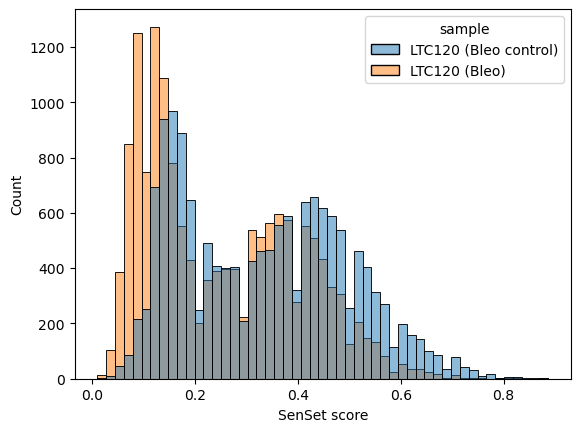

In [53]:
sns.histplot(
    bb,
    x="SenSet score",
    hue="sample",
)

<Axes: >

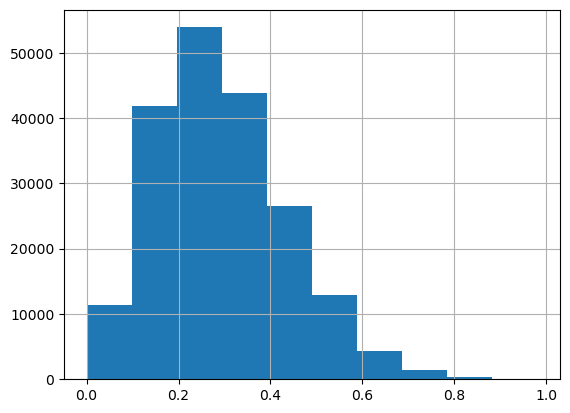

In [45]:
adata.obs['SenSet score'].hist()

In [43]:
ave_score

array([0.47169811, 0.5       , 0.05660377, ..., 0.36792453, 0.26415094,
       0.14150943], shape=(196565,))

In [108]:
gene_sets = {'SenSet': senset}

def ss_adata(subj, cond):
    idx_control = (adata.obs['sample'] == f"{subj} ({cond} control)").values.nonzero()[0]
    idx_treat = (adata.obs['sample'] == f"{subj} ({cond})").values.nonzero()[0]

    rand_control = np.random.choice(idx_control, size=1000, replace=False)
    rand_treat = np.random.choice(idx_treat, size=1000, replace=False)
    rand_idx = np.concatenate([rand_control, rand_treat])

    ad = adata[rand_idx]
    assert ad.obs['sample'].unique().size == 2

    expr = pd.DataFrame(
        ad.X.T.toarray() if hasattr(ad.X, "toarray") else ad.X.T,
        index=ad.var_names,
        columns=ad.obs_names
    )
    print(f"Analyzing matrix of shape {expr.shape}")

    ss = gp.ssgsea(
        data=expr,
        gene_sets=gene_sets,
        sample_norm_method='rank',   # ranks each cell’s genes
        outdir=None,                 # don’t write files
        min_size=5,                  # drop any gene‐sets <5 genes
        max_size=5000,
        permutation_num=0,           # no permutations needed for a score
        no_plot=True,
        threads=4,
    )
    df = ss.res2d
    df["Condition"] = ad.obs["sample"].values
    return df

In [109]:
ss = ss_adata("LTC113", "Bleo")

Analyzing matrix of shape (22923, 2000)


<Axes: xlabel='NES', ylabel='Count'>

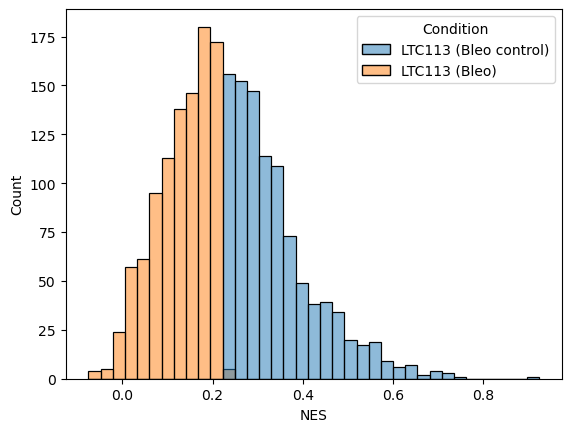

In [110]:
sns.histplot(
    ss,
    x="NES",
    hue="Condition",
)

In [36]:
ss

,Name,Term,ES,NES,Condition
0,CTACAGAGTCAGTCTA-1,SenSet,7217.442551,0.94169,LTC113 (Bleo control)
1,TGGTGATCACTATCGA-1,SenSet,6776.065833,0.884102,LTC113 (Bleo control)
2,TCCGATCAGGCTGAAC-1,SenSet,6357.850499,0.829536,LTC113 (Bleo control)
3,TCATTCAGTCATCCGG-1,SenSet,6147.835676,0.802134,LTC113 (Bleo control)
4,CATTCATCATGACGGA-1,SenSet,5643.112124,0.736281,LTC113 (Bleo control)
...,...,...,...,...,...
1995,ACTTCGCTCTGACAGT-1-1,SenSet,-21.846415,-0.00285,LTC113 (Bleo)
1996,CAGCACGCAGCCGGTT-1,SenSet,9.889599,0.00129,LTC113 (Bleo)
1997,TCATGGAAGCGCATCC-1,SenSet,2.759448,0.00036,LTC113 (Bleo)
1998,GACGTTAGTGGTCTCG-1,SenSet,2.39299,0.000312,LTC113 (Bleo)
